In [1]:
%%capture
!pip install openpyxl==3.0.0
!pip install emoji
!pip install vaderSentiment
!pip install contractions

In [2]:
import openpyxl
print(f"openpyxl version: {openpyxl.__version__}")

import pandas as pd
import numpy as np
import re 
import time
import matplotlib.pyplot as plt
import seaborn as sns

from emoji import UNICODE_EMOJI
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import unicodedata
import contractions

openpyxl version: 3.0.0


In [3]:
# Mount drive to access files
%%capture
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive"

In [4]:
tweets_clean = pd.read_parquet('drive/My Drive/data/abudhabigp_tweets_clean.gzip')

print(len(tweets_clean))
tweets_clean.head()

252634


,id,date,interval,tweet,tweet_clean,hashtags,tweet_len,junk
0,0,2021-12-12 13:00:00,13:00,@MercedesAMGF1 My nerves are wrecking the anxi...,@MercedesAMGF1 My nerves are wrecking the anxi...,[],91,False
1,1,2021-12-12 13:00:00,13:00,Lets go! @LewisHamilton https://t.co/QiL9lWU6RQ,Lets go! @LewisHamilton,[],48,False
2,2,2021-12-12 13:00:00,13:00,Turn 1 anxiety #AbuDhabiGP,Turn 1 anxiety,[abudhabigp],27,False
3,3,2021-12-12 13:00:00,13:00,@piersmorgan @LewisHamilton Real brits pick wh...,@LewisHamilton Real brits pick who thay follow...,[],158,False
4,4,2021-12-12 13:00:00,13:00,@chris_tiffa @LewisHamilton Haha aye funny tha...,@LewisHamilton Haha aye funny that i dont trus...,[],73,False


In [6]:
# Replace curly quotes
tweets_clean['tweet_clean'] = [re.sub('’', "'", x) for x in tweets_clean['tweet_clean']]
tweets_clean['tweet_clean'] = [re.sub('“|”', '"', x) for x in tweets_clean['tweet_clean']]

In [7]:
s = 0
for i in [re.findall('[’“”]', x) for x in tweets_clean['tweet_clean']]:
  if len(i) > 0:
    s += 1
print(s)

0


# Sentiment Analysis with VADER

To further analyse the rollercoaster of emotions expressed during this final race of the season, I employ VADER (*Valence Aware Dictionary and sEntiment Reasoner*; [Hutto & Gilbert, 2014](https://ojs.aaai.org/index.php/ICWSM/article/view/14550)), a rule-based model, to derive sentiment polarities. VADER is fast and is optimised for social media texts such as tweets. 

In [10]:
# Initialise sentiment analyser
sentiment = SentimentIntensityAnalyzer()
sentiment

In [12]:
# Demo 
tweet = tweets_clean['tweet_clean'][123]
print(tweet)
sentiment.polarity_scores(tweet)

What a season. Let's go SUPER MAX 🏆


{'compound': 0.6841, 'neg': 0.0, 'neu': 0.602, 'pos': 0.398}

In [13]:
vader_df = tweets_clean[['id', 'interval', 'tweet_clean']].copy()

# Get sentiment scores for all tweets
vader_df['vader'] = vader_df['tweet_clean'].apply(lambda x: sentiment.polarity_scores(x))
vader_df['vader_neg'] = [x['neg'] for x in vader_df['vader']]
vader_df['vader_pos'] = [x['pos'] for x in vader_df['vader']]
vader_df['vader_comp'] = [x['compound'] for x in vader_df['vader']]

vader_df.head()

,id,interval,tweet_clean,vader,vader_neg,vader_pos,vader_comp
0,0,13:00,@MercedesAMGF1 My nerves are wrecking the anxi...,"{'neg': 0.159, 'neu': 0.373, 'pos': 0.467, 'co...",0.159,0.467,0.9916
1,1,13:00,Lets go! @LewisHamilton,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,0.0000
2,2,13:00,Turn 1 anxiety,"{'neg': 0.459, 'neu': 0.541, 'pos': 0.0, 'comp...",0.459,0.000,-0.1779
3,3,13:00,@LewisHamilton Real brits pick who thay follow...,"{'neg': 0.0, 'neu': 0.921, 'pos': 0.079, 'comp...",0.000,0.079,0.3612
4,4,13:00,@LewisHamilton Haha aye funny that i dont trus...,"{'neg': 0.154, 'neu': 0.511, 'pos': 0.335, 'co...",0.154,0.335,0.4936


In [14]:
# Most positive and negative tweets
pd.DataFrame({
    'top_pos': vader_df.sort_values(by = ['vader_comp'], ascending = False)['tweet_clean']\
              .head(10).reset_index(drop=True),
    'top_neg': vader_df.sort_values(by = ['vader_comp'], ascending = True)['tweet_clean']\
              .head(10).reset_index(drop=True)
            })

,top_pos,top_neg
0,"WELL DESERVED, MAX!!!!!!!!! 🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡...",😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭...
1,@LewisHamilton Great victory of @Max33Verstapp...,WHAT A WOW!!!!😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭...
2,@MercedesAMGF1 Let's all laugh at Pamilton 😂😂😂...,Loser Loser Loser Loser Loser Loser Loser Lose...
3,SUPER MAX 🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡...,MAX VERSTAPPEN IS FORMULA 1 CHAMPION 😭😭😭😭😭😭😭😭😭...
4,"@LewisHamilton How's things hun? ""Dangerous dr...",SIMPLY LOVELY MAX VERSTAPPEN IS FORMULA 1 CHAM...
5,"Lewis Hamilton had the fastest car, illegal en...",THIS RACE MAN!!!!!!!!!! WHAT WAS THAAAAAAAAT!!...
6,🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉MAX VERST...,MAX VERSTAPPEN FIA FORMULA 1 WORLD DRIVERS CHA...
7,🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡🧡...,WHY DID THEY NOT PIT LEWIS!!!!!??????????? 😭😭😭...
8,@F1 @Max33Verstappen ❤️ MASSA ☝️ this one shou...,MERCEDES HAVE BEEN TERRIBLE ON STRATEGY ALL SE...
9,"@MercedesAMGF1 You are WRONG, again. There is ...",OHHHHHHHHH MYYYYYYYYYYY FUCKKKKKKKKINGGGGGGGGG...


Consistent with the heuristics identified by the authors of VADER, emojis, capital words and exclamations tend to skew the sentiment to the extremes. 

There are some incorrectly assessed sentiments (e.g. 😭 used to express happiness). 

69326 tweets (27.44%) have a compound score of 0.


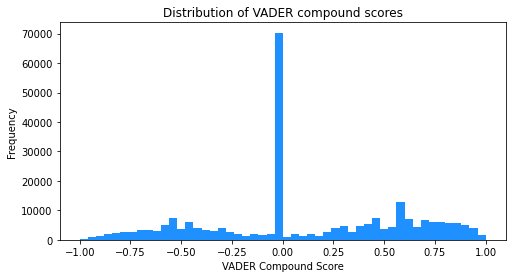

In [23]:
n_neutrals = len(vader_df[vader_df['vader_comp'] == 0])
print(f"{n_neutrals} tweets ({n_neutrals/len(vader_df)*100:.2f}%) have a compound score of 0.")

vader_df['vader_comp'].plot(kind = 'hist', bins = 50, 
                            color = 'dodgerblue',
                            figsize = (8, 4))
plt.xlabel('VADER Compound Score')
plt.title('Distribution of VADER compound scores');

In [17]:
# Check neutrals
vader_df.loc[vader_df['vader_comp'] == 0, 'tweet_clean'].sample(20, random_state = 1234)

90692                                 THIS IS A WILD ENDING
3532                                        Let's go Max!!!
1310                                   LETS GO MAX!!!!!!!!!
51999                                          is legendary
92206                                      Get in there Max
196336    We all have so so much to learn from various s...
214888    @LewisHamilton Imagine watching the last race ...
93272                          Verstappen into the hairpin:
83072                         Naaa this is a proper finale!
5336                            Final F1 of the season!! or
142526                                      WHAT A SPORT. 🏁
21732     Lap 10/58: Mick stays right on the tail of Lat...
67692                              Hamilton leads, Kimi DNF
249353              @redbullracing @fia You were saying....
135599                            que hombre Max Verstappen
198561                                    Merc pit to FIA :
84647                        COME ON LEW

A lot of the neutral tweets are actually not neutral, but were not picked up by VADER not least because some of them were highly contextual, or had dragged words not recognised by VADER. 

Let's try to see how prevalent the latter problem is by removing repeated characters. Note that this is imperfect as it does not distinguish genuine repeated characters (e.g. 'hell' gets truncated to 'hel'). 

In [21]:
# Demo
test_text = "whattttt the hellllll noooooooo"
re.compile(r'(.)\1{2,}', re.IGNORECASE).sub(r'\1', test_text)

'what the hel no'

In [22]:
vader_trunc_df = tweets_clean[['id', 'interval', 'tweet_clean']].copy()

# Truncate repeated characters 
vader_trunc_df['tweet_trunc'] = [re.compile(r'(.)\1{2,}', re.IGNORECASE).sub(r'\1', x) for x in vader_trunc_df['tweet_clean']]

# Get sentiment scores for all truncated tweets
vader_trunc_df['vader'] = vader_trunc_df['tweet_trunc'].apply(lambda x: sentiment.polarity_scores(x))
vader_trunc_df['vader_neg'] = [x['neg'] for x in vader_trunc_df['vader']]
vader_trunc_df['vader_pos'] = [x['pos'] for x in vader_trunc_df['vader']]
vader_trunc_df['vader_comp'] = [x['compound'] for x in vader_trunc_df['vader']]

After truncating repeated characters, 67275 tweets (26.63%) have a compound score of 0


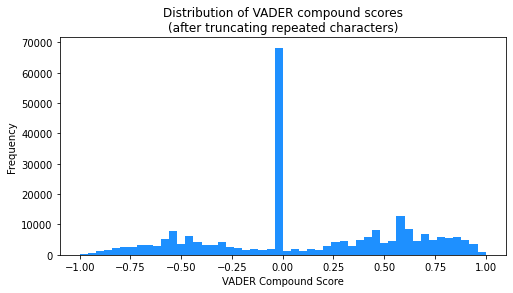

In [ ]:
n_neutrals = len(vader_trunc_df[vader_trunc_df['vader_comp'] == 0])
print("After truncating repeated characters,", 
      f"{n_neutrals} tweets ({n_neutrals/len(vader_trunc_df)*100:.2f}%) have a compound score of 0")

vader_trunc_df['vader_comp'].plot(kind = 'hist', bins = 50, 
                                  color = 'dodgerblue', 
                                  figsize = (8, 4))
plt.xlabel('VADER Compound Score')
plt.title('Distribution of VADER compound scores\n(after truncating repeated characters)');

Removing repeated characters produced a slight reduction in the number of neutral tweets. 

### Subject Identification

In this section, I will attempt to identify who the tweets are referencing, so that I can separately analyse the sentiments about the title protaganists across the race. For simplicity, I will use a rule-based system.

In [24]:
# Define regexes that capture the most common references for Max and Lewis
mv_regex = '(?i)(?<!\\w)(@?max33verstappen|max\s?verstappen|super\s?max|maxverstappen33|maxs?|verstappens?|[a-z]+stappens?|MV33|MV|VER)(?!\\w)'
lh_regex = '(?i)(?<!\\w)(@?lewishamilton|lewis\s?hamilton|lewishamilton44|lewis|hamiltons?|[a-z]+miltons?|LH44|LH|HAM)(?!\\w)'

In [25]:
## Identify the protaganists

# Standardise the driver references
vader_trunc_df['subbed_tweets'] = [re.sub(mv_regex, 'VER', str(x)) for x in vader_trunc_df['tweet_clean']]
vader_trunc_df['subbed_tweets'] = [re.sub(lh_regex, 'HAM', str(x)) for x in vader_trunc_df['subbed_tweets']]

# Identify the references
vader_trunc_df['drivers'] = [re.findall('(?<!\\w)VER|HAM(?!\\w)', str(x)) for x in vader_trunc_df['subbed_tweets']]

# Get the drivers referenced -- either VER or HAM or a set 
ref = []
for i in range(0, len(vader_trunc_df)):
  if len(set(vader_trunc_df['drivers'][i])) == 1: 
    ref.append(vader_trunc_df['drivers'][i][0])
  elif len(set(vader_trunc_df['drivers'][i])) > 1:
    ref.append('VER-HAM') 
  else:
    ref.append(0)

vader_trunc_df['first_ref'] = ref
vader_trunc_df = vader_trunc_df.drop(columns=['drivers', 'subbed_tweets'])

In [26]:
vader_trunc_df['first_ref'].value_counts()

0          134599
VER         61284
HAM         38743
VER-HAM     18008
Name: first_ref, dtype: int64

In [27]:
# Create individual dataframes with driver's tweets
ver_tweets = vader_trunc_df[(vader_trunc_df['first_ref'] == 'VER')][['id', 'interval', 'vader_comp']]

ham_tweets = vader_trunc_df[(vader_trunc_df['first_ref'] == 'HAM')][['id', 'interval', 'vader_comp']]

both_tweets = vader_trunc_df[(vader_trunc_df['first_ref'] == 'VER-HAM')][['id', 'interval', 'vader_comp']]

print(f"Number of VER tweets: {len(ver_tweets)}\n", 
      f"Number of HAM tweets: {len(ham_tweets)}\n", 
      f"Number of VER + HAM tweets: {len(both_tweets)}")

Number of VER tweets: 61284
 Number of HAM tweets: 38743
 Number of VER + HAM tweets: 18008


In [28]:
# Rolling average
div = 500 
ver_tweets['rolling_avg'] = ver_tweets['vader_comp'].rolling(int(len(ver_tweets)/div)).mean()
ham_tweets['rolling_avg'] = ham_tweets['vader_comp'].rolling(int(len(ham_tweets)/div)).mean()
both_tweets['rolling_avg'] = both_tweets['vader_comp'].rolling(int(len(both_tweets)/div)).mean()

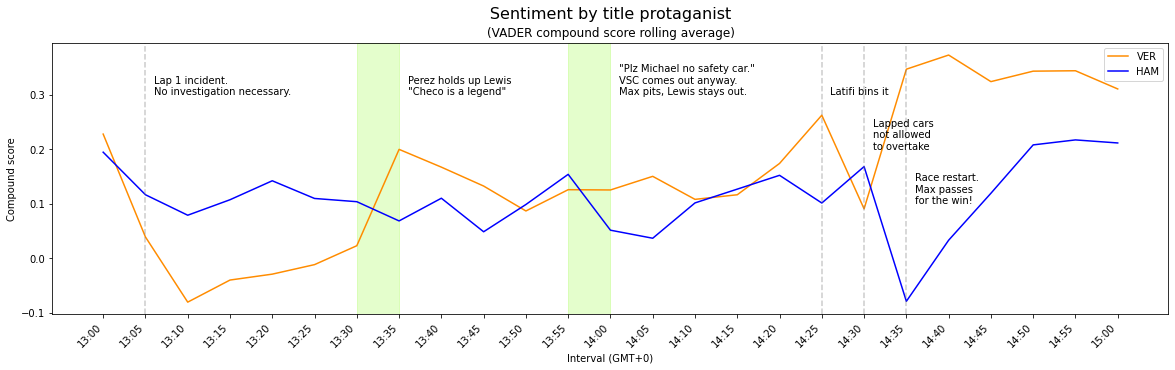

In [63]:
plt.subplots(figsize=(20, 5))

sns.lineplot(x = 'interval',
             y = 'rolling_avg',
             data = ver_tweets,
             label = 'VER', ci = None, color = 'darkorange')

sns.lineplot(x = 'interval',
             y = 'rolling_avg',
             data = ham_tweets,
             label = 'HAM', ci = None, color = 'blue')

plt.xticks(rotation = 45, ha = 'right')

plt.axvline(x = '13:05', color = 'grey', alpha = 0.4, linestyle = '--')
plt.text(x = 1.2, y = 0.3, s = 'Lap 1 incident.\nNo investigation necessary.', horizontalalignment = 'left', rotation=0)

plt.axvspan(6, 7, color='lawngreen', alpha = 0.2)
plt.text(x = 7.2, y = 0.3, s = 'Perez holds up Lewis\n"Checo is a legend"', horizontalalignment = 'left', rotation=0)

plt.axvspan(11, 12, color='lawngreen', alpha = 0.2)
plt.text(x = 12.2, y = 0.3, s = '"Plz Michael no safety car."\nVSC comes out anyway.\nMax pits, Lewis stays out.', horizontalalignment = 'left', rotation=0)

plt.axvline(x = '14:25', color = 'grey', alpha = 0.4, linestyle = '--')
plt.text(x = 17.2, y = 0.3, s = 'Latifi bins it', horizontalalignment = 'left', rotation=0)

plt.axvline(x = '14:30', color = 'grey', alpha = 0.4, linestyle = '--')
plt.text(x = 18.2, y = 0.2, s = 'Lapped cars\nnot allowed\nto overtake', horizontalalignment = 'left', rotation=0)

plt.axvline(x = '14:35', color = 'grey', alpha = 0.4, linestyle = '--')
plt.text(x = 19.2, y = 0.1, s = 'Race restart.\nMax passes\nfor the win!', horizontalalignment = 'left', rotation=0)

plt.suptitle('       Sentiment by title protaganist', fontsize=16)
plt.title('(VADER compound score rolling average)', fontsize=12)
plt.xlabel('Interval (GMT+0)')
plt.ylabel('Compound score');

# Wordcloud

What were people talking about at each significant segment of the race?

### Clean the tweets for wordcloud

In [65]:
%%capture
import unicodedata

try:
  import contractions
except:
  !pip install contractions
  import contractions

import nltk 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords  
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from wordcloud import WordCloud

In [98]:
# Lemmatizer
lemmatizer = WordNetLemmatizer()

# Stopwords list
stop_words = stopwords.words("english")
stop_words.extend(['fuck', 'shit', 'race', 'lap', 'amp', 'ok', 'yeah', 'boy']) 
print(len(stop_words))
stop_words = list(set(stop_words))
print(len(stop_words))

187
187


In [68]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('test tweet 🙏🏻👏🏻🙌🏻🤞🏻')

'test tweet '

In [69]:
# Function to convert to wordnet tags for lemmatisation 
def pos_tag_wordnet(tagged_tokens): 
  tag_dict = {"J": wordnet.ADJ,
              "N": wordnet.NOUN,
              "V": wordnet.VERB,
              "R": wordnet.ADV}
  # Default is wordnet.NOUN if not found in tag_dict
  wordnet_tagged_tokens = [(word, tag_dict.get(tag[0], wordnet.NOUN)) 
                            for word, tag in tagged_tokens]
  
  return wordnet_tagged_tokens 

In [70]:
# Sentence cleaner and lemmatiser 
def cleaner_lemmatiser(s): 

  # Remove all handles 
  s = re.sub('(?i)(?<!\\w)@[a-z0-9_]+(?!\\w)', '', s)

  # Remove accented characters (custom function)
  s = remove_accented_chars(s)

  # Expand contractions 
  s = contractions.fix(s)

  # Remove everything that isn't letters and spaces
  s = re.sub('(?i)[^a-z\s]', '', s)

  # Tokenize
  tokens = nltk.word_tokenize(s)

  # Filter stopwords
  tokens_nostop = []  
  for t in tokens:  
      if t not in stop_words: # defined earlier  
          tokens_nostop.append(t)

  # POS tagging
  tagged_tokens = nltk.pos_tag(tokens_nostop)

  # Convert to WordNet POS tags (custom function)
  wordnet_tokens = pos_tag_wordnet(tagged_tokens)

  # Lemmatisation
  lemmatised_sentence = ' '.join(lemmatizer.lemmatize(word, tag) for word, tag in wordnet_tokens)
  
  return lemmatised_sentence

In [71]:
# Lemmatise all tweets 
%%time
vader_trunc_df['tweet_lemma'] = [cleaner_lemmatiser(x) for x in vader_trunc_df['tweet_trunc']]

CPU times: user 3min 21s, sys: 3.44 s, total: 3min 24s
Wall time: 3min 24s


Find top useless words to remove from wordcloud by passing it into the `stopwords` argument

In [73]:
# Find top words to identify additional stop words to remove
all_text = " ".join(vader_trunc_df['tweet_lemma']).lower()
all_text_tokens = nltk.word_tokenize(all_text)

In [74]:
from collections import Counter
counts = Counter(all_text_tokens)

In [75]:
tok = []
cnt = []
for k, v in dict(counts).items():
  tok.append(k)
  cnt.append(v)

print(list(pd.DataFrame({'tokens': tok, 'counts': cnt}).sort_values('counts', ascending=False).head(50)['tokens']))

['max', 'i', 'fia', 'lewis', 'hamilton', 'verstappen', 'go', 'the', 'what', 'car', 'champion', 'world', 'season', 'get', 'win', 'you', 'latifi', 'f', 'that', 'end', 'fuck', 'championship', 'let', 'this', 'like', 'well', 'last', 'masi', 'make', 'one', 'safety', 'driver', 'give', 'it', 'decision', 'do', 'race', 'mercedes', 'michael', 'way', 'rule', 'would', 'super', 'year', 'need', 'yes', 'come', 'lap', 'joke', 'see']


In [88]:
additional_stopwords = ['i', 'race', 'go', 'the', 'what', 'car', 'champion', 'lap', 
                        'world', 'season', 'get', 'win', 'you', 'that', 
                        'end', 'f1', 'fuck', 'championship', 'let', 'this', 'like', 
                        'well', 'last', 'make', 'one', 'driver', 'give', 'it', 
                        'decision', 'do', 'mercedes', 'rule', 'would', 'way', 
                        'year', 'need', 'yes', 'come', 'see', 'now', 'day', 'yet', 
                        'pas?', 'amp', 
                        'oh', 'he', 'so', 'is', 'to', 'lol', 
                        'abu', 'dhabi', 'abudhabi']

In [99]:
stop_words.extend(additional_stopwords)
print(len(stop_words))
stop_words = np.unique(stop_words).tolist()
print(len(stop_words))

240
223


In [78]:
def wordcloud_cleaner(text):
  text = re.sub('(?i)(?<!\\w)(@[a-z0-9_]+|redbullracing|mercedesamgf1)(?!\\w)', '', text) # handles
  text = re.sub('(?i)(?<!\\w)(pit stop)(?!\\w)', 'pitstop', text)
  text = re.sub('(?i)(?<!\\w)(alfa\s?romeo)(?!\\w)', 'AlfaRomeo', text)
  text = re.sub('(?i)(?<!\\w)(red bull|redbull)(?!\\w)', 'RedBull', text)
  text = re.sub('(?i)(?<!\\w)(michael masi|masi|michael)(?!\\w)', 'Masi', text)
  text = re.sub('(?i)(?<!\\w)(christian horner|christian|horner)(?!\\w)', 'Horner', text)
  text = re.sub('(?i)(?<!\\w)(toto\s?wolff|toto|wolff)(?!\\w)', 'Toto', text)
  text = re.sub('(?i)(?<!\\w)(nicholas\slatifi|nicholas|latifi)(?!\\w)', 'Latifi', text)
  text = re.sub('(?i)(?<!\\w)((super)? super max)(?!\\w)', 'SuperMax', text)
  text = re.sub('(?i)(?<!\\w)(virtual\s?safety\s?car|safety\s?car|v?sc)(?!\\w)', 'SafetyCar', text) 
  text = re.sub('(?i)(?<!\\w)(lewis|hamiltons?|lewishamilton)(?!\\w)', '', text) # remove ham and max
  text = re.sub('(?i)(?<!\\w)(max|verstappens?|max33verstappen)(?!\\w)', '', text)
  text = re.sub('(?i)(?<!\\w)(schecoperez|checo|perez|sergio)(?!\\w)', 'Perez', text) 
  text = re.sub(' +', ' ', text)
  return text

In [103]:
# A list of events and their descriptions
event_ts = [(['13:05'], 'race start'), 
            (['13:30', '13:35'], "Perez's defence"), 
            (['13:55', '14:00'], 'Virtual Safety Car'), 
            (['14:25'], "Latifi's crash"), 
            (['14:30'], '"lapped cars are not allowed to overtake"'), 
            (['14:35'], "race restart and Max's overtake")]

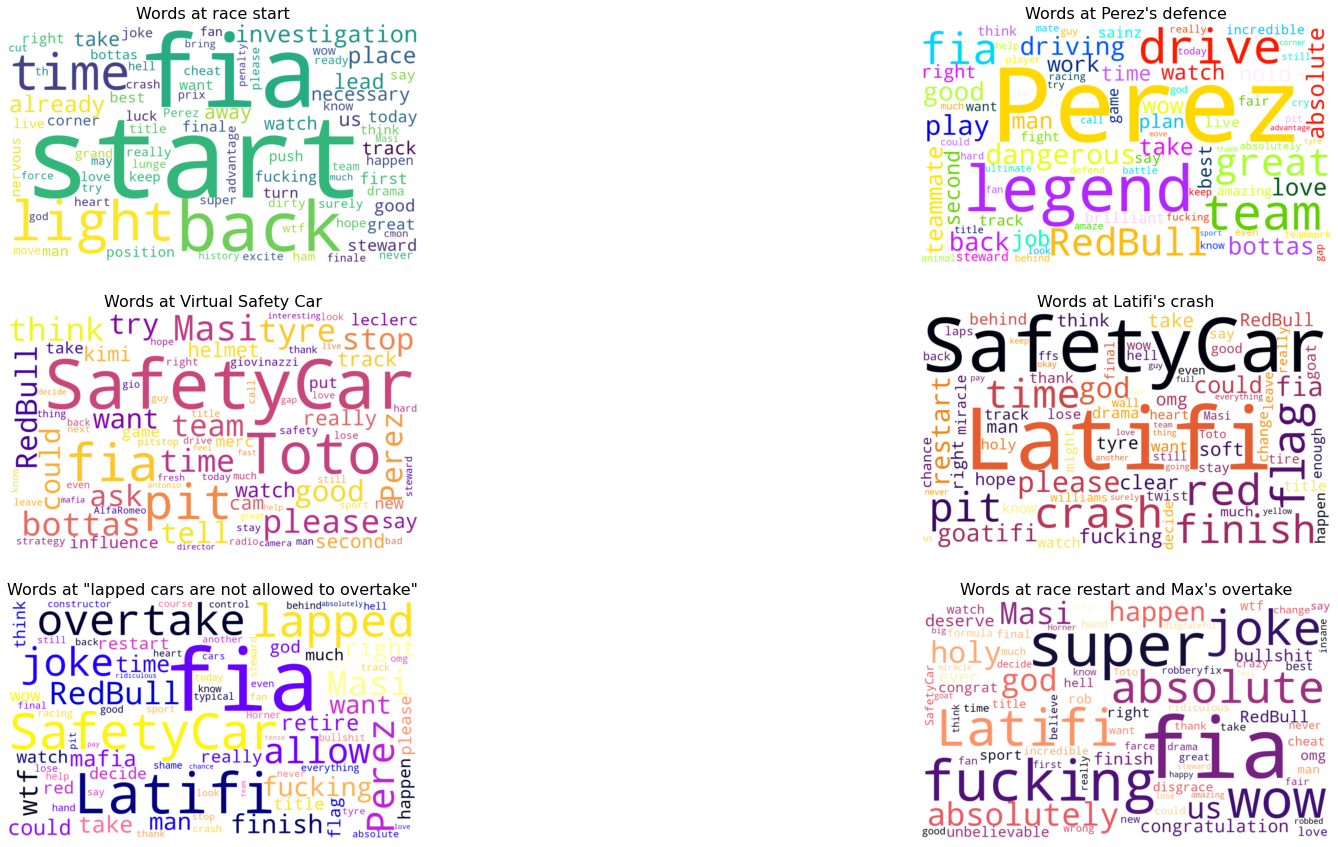

In [105]:
fig, axs = plt.subplots(3, 2, figsize=(30, 15))

colors = ['viridis', 'gist_ncar', 'plasma', 'inferno', 'gnuplot2', 'magma']

n = 0 
for ax in axs.reshape(-1): 
  
  text = " ".join(vader_trunc_df[vader_trunc_df['interval'].isin(event_ts[n][0])]['tweet_lemma']).lower() 
  text = wordcloud_cleaner(text)
  
  # Creating word_cloud with text as argument in .generate() method
  word_cloud = WordCloud(collocations = False, # no bigrams 
                         background_color = 'white', 
                         width=1200, height=700, 
                         #max_font_size=98, 
                         max_words=80, 
                         prefer_horizontal = 0.95, 
                         normalize_plurals=True, 
                         colormap = colors[n], 
                         stopwords=stop_words
                         ).generate(text)
  
  ax.imshow(word_cloud, interpolation='bilinear')
  ax.set_title(f"Words at {event_ts[n][1]}", fontsize=16)
  ax.axis('off')
  n += 1